In [6]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import Math, display
from matplotlib.axes import Axes
from scipy import constants as const
from scipy.integrate import quad
from scipy.optimize import root_scalar
from scipy.signal import argrelmax,argrelmin
from tqdm import tqdm

import fewfermions.analysis.units as si
from fewfermions.simulate.traps.twod.trap import PancakeTrap
from fewfermions.style import FIGS_PATH, setup

from helpers import *

colors, colors_alpha = setup()

# Solving the radial SE to see when those get populated

In [7]:
initial_power = 49 * si.uW 

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0 * si.G / si.cm,
    grad_r=0,
    power_tweezer= initial_power,
    waist_tweezer=1 * si.um,
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 1064 * si.nm,
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

x, y, z = trap.x, trap.y, trap.z

In [8]:
trap.subs(trap.get_potential())

-2.67062937174555e-24*z + 5.61241215754764e-29/pi - 5.61241215754764e-29*exp(1000000000000.0*(-2*x**2 - 2*y**2)/(1132096000000.0*z**2/pi**2 + 1))/(pi*(1132096000000.0*z**2/pi**2 + 1))

In [4]:
initial_power = 291.5 * si.uW

#parameters for lithium setup
wvl = 1064 * si.nm
omega_l = 2 * np.pi * const.c / wvl
omega_0 = 2 * np.pi * const.c / (671 * si.nm)
gamma = 2 * np.pi * 5.8724 * const.mega

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z=15 * si.G / si.cm,
    grad_r=0,
    power_tweezer=initial_power,
    waist_tweezer=1.838 * si.um,

    wvl = 1064 * si.nm,
    omega_0 = 2 * np.pi * const.c / (671 * si.nm),
    a = (3 * sp.pi * const.c**2) / (2 * omega_0**3)* (gamma / (omega_0 - omega_l) + gamma / (omega_0 + omega_l)),
    m = 6.0151228 * const.value("atomic mass constant"),
    mu_b = const.value("Bohr magneton"),
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

x, y, z = trap.x, trap.y, trap.z

In [49]:
aspect_ratio = trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer()
_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio_latex} \\approx {trap.subs(aspect_ratio).evalf():.2f}"))

<IPython.core.display.Math object>

In [52]:
trap[trap.power_tweezer] = 0.52* initial_power
# Solve the hamiltonian numerically in axial direction
energies, states, potential, coords = trap.nstationary_solution(
    trap.x, (-0.5 * axial_width, 3 * axial_width), n_pot_steps, k=n_levels
)

pot_ax = trap.subs(trap.get_potential())
pot_diff_ax = sp.diff(pot_ax, trap.x)
pot_diff2_ax = sp.diff(pot_diff_ax, trap.x)
pot_diff3_ax = sp.diff(pot_diff2_ax, trap.x)
pot_diff_ax_numpy = sp.lambdify(trap.x, pot_diff_ax.subs({x: 0, y: 0}))
pot_diff2_ax_numpy = sp.lambdify(trap.x, pot_diff2_ax.subs({x: 0, y: 0}))
pot_diff3_ax_numpy = sp.lambdify(trap.x, pot_diff3_ax.subs({x: 0, y: 0}))

barrier = root_scalar(
    pot_diff_ax_numpy,
    x0=1.5 * float(trap.subs(axial_width)),
    fprime=pot_diff2_ax_numpy,
    xtol=1e-18,
    fprime2=pot_diff2_ax_numpy,
).root

# States that are below the potential barrier
bound_states = energies < potential(barrier)


# Density of states is larger on the left than on the right
# Likely that the state in question is a true bound state
true_bound_states = np.logical_and(
    bound_states,
    np.sum(states[:, coords[x] < barrier] ** 2, axis=1)
    > np.sum(states[:, coords[x] > barrier] ** 2, axis=1),
)

3.5217732675329976e-34


Text(0, 0.5, 'E / h (kHz)')

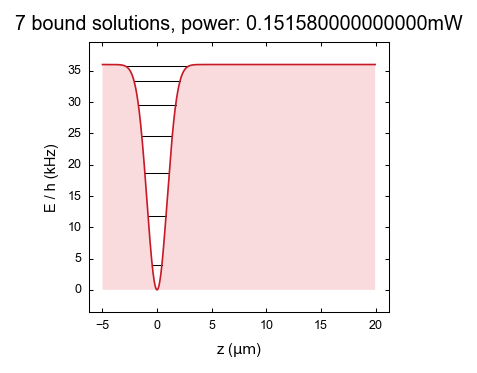

In [53]:
width_np = float(trap.subs(axial_width))

z_np = np.linspace(-0.5 * width_np, 2 * width_np, num=1000)

ax: plt.Axes
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# ax.set_title("Axial")
abs_min = np.min(potential(z_np))
print(abs_min)
ax.fill_between(
    z_np / si.um,
    potential(z_np) / const.h / si.kHz,
    abs_min / const.h / si.kHz,
    fc=colors_alpha["red"],
    alpha=0.5,
)
# ax2 = ax.twinx()

for i, bound in enumerate(true_bound_states):
    if not bound:
        continue
    energy = energies[i]
    state = states[i]
    ax.plot(
        z_np / si.um,
        np.where(
            (energy > potential(z_np)) & (z_np < barrier),
            energy / const.h / si.kHz,
            np.nan,
        ),
        c="k",
        lw=0.5,
        marker="None",
    )
    # ax1.plot(coords[trap.z], state**2, marker="None", c="k")

ax.plot(z_np / si.um, potential(z_np) / const.h / si.kHz, marker="None")
ax.set_title(f"{np.sum(true_bound_states)} bound solutions, power: {trap.subs(trap.power_tweezer)/si.mW}mW")
ax.set_xlabel(r"z ($\mathrm{\mu m}$)")
ax.set_ylabel(r"E / h (kHz)")


# Solving radial direction separatly

<IPython.core.display.Math object>

[7.04017576e+24 1.55764305e+19 2.03219750e+14 7.77300227e+09
 7.43763814e+05 1.75838686e+02 1.16136010e-01] s
-9.92574367372403e-31


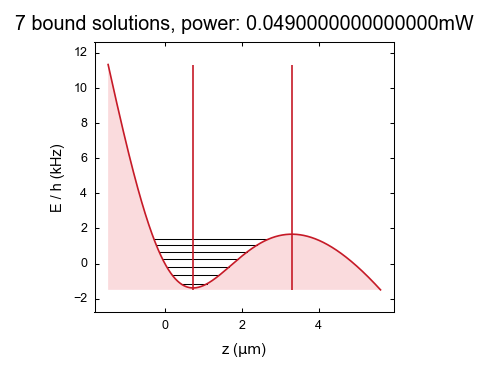

In [22]:
from helpers import *

initial_power = 49 * si.uW

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0 * si.G / si.cm,
    grad_r=0,
    power_tweezer= initial_power,
    waist_tweezer=1 * si.um,
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 1064 * si.nm,
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

x, y, z = trap.x, trap.y, trap.z

aspect_ratio = trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer()
_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio_latex} \\approx {trap.subs(aspect_ratio).evalf():.2f}"))


plot_solutions(trap,100,-0.5*zr,1.9*zr,n_pot_steps=1000,display_plot=-2,state_mult=1e3)

<IPython.core.display.Math object>

[2.62536051e+67 9.76559172e+59 2.04847784e+53 1.16567274e+47
 1.46026265e+41 3.65790780e+35 1.73924943e+30 1.52473570e+25
 2.43003841e+20 7.02643563e+15 3.72319935e+11 3.70687856e+07
 7.27419244e+03 3.08507686e+00 3.52499553e-03] s
-1.235754055253792e-30


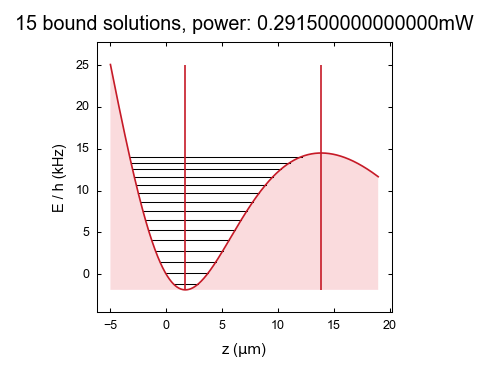

In [17]:
from helpers import *

initial_power = 291.5 * si.uW

#parameters for lithium setup
wvl = 1064 * si.nm
omega_l = 2 * np.pi * const.c / wvl
omega_0 = 2 * np.pi * const.c / (671 * si.nm)
gamma = 2 * np.pi * 5.8724 * const.mega

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z=15 * si.G / si.cm,
    grad_r=0,
    power_tweezer=initial_power,
    waist_tweezer=1.838 * si.um,

    wvl = 1064 * si.nm,
    omega_0 = 2 * np.pi * const.c / (671 * si.nm),
    a = (3 * sp.pi * const.c**2) / (2 * omega_0**3)* (gamma / (omega_0 - omega_l) + gamma / (omega_0 + omega_l)),
    m = 6.0151228 * const.value("atomic mass constant"),
    mu_b = const.value("Bohr magneton"),
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

x, y, z = trap.x, trap.y, trap.z

aspect_ratio = trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer()
_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio_latex} \\approx {trap.subs(aspect_ratio).evalf():.2f}"))


plot_solutions(trap,100,-0.5*zr,1.9*zr,n_pot_steps=1000,display_plot=-2,state_mult=1e3)

5.1717890943465785e-33
26.564333266068875
25.96489910768727
25.382996351948655
24.818065021051286
24.269570728094312
23.73700386737578
23.21987890025091
22.71773374263102
22.23012926268299
21.756648900495044
21.2968984256903
20.8505058545992
20.41712155624778
19.996418586981296
19.588093308397557


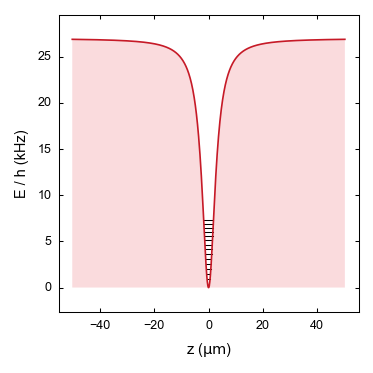

In [23]:

plot_solutions_ax(trap,15,-17*zr,17*zr,n_pot_steps=1000,display_plot=-2,state_mult=1e3)

2.528116823253725e-34
25.695640087867233
23.211447531392245
20.82326989690704
18.533513496817722
16.344870905888378
14.260379578986871
12.283498634669748
10.418211686394796
8.669168207811033
7.041884072722405
5.5430371954550886
4.180924936038319
2.9662175320690007
1.9133091495166965
1.0430571002545062
0.3894904467789659
0.010187209408827964


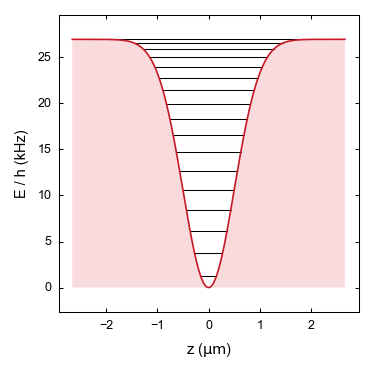

In [24]:
plot_solutions_rad(trap,100,-0.9*zr,0.9*zr,n_pot_steps=1000,display_plot=-2,state_mult=1e3)

# Solve 3D SE and look at step plot

<IPython.core.display.Math object>

[2.14636597e+55 3.07658108e+48 2.39971369e+42 4.91850572e+36
 2.15913958e+31 1.85351395e+26 2.97267208e+21 8.72400278e+16
 4.67207122e+12 4.63299621e+08 8.82595867e+04 3.48134637e+01
 3.17758787e-02] s
-7.363216798479622e-31


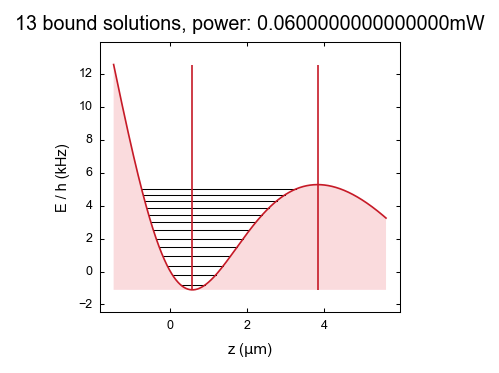

In [53]:
from helpers import *

initial_power = 49 * si.uW

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0 * si.G / si.cm,
    grad_r=0,
    power_tweezer= initial_power,
    waist_tweezer=1 * si.um,
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 1064 * si.nm,
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

x, y, z = trap.x, trap.y, trap.z

aspect_ratio = trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer()
_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio_latex} \\approx {trap.subs(aspect_ratio).evalf():.2f}"))


plot_solutions(trap,100,-0.5*zr,1.9*zr,n_pot_steps=1000,display_plot=-2,state_mult=1e3)

In [ ]:
n_spill_steps = 100

trap[trap.power_tweezer] = initial_power

spill_power_factor = np.linspace(0.7, 0.52, num=n_spill_steps)
powers = trap[trap.power_tweezer] * spill_power_factor
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 30
# Resolution of the potential when solving numerically
n_pot_steps = 20

energies, states, potential, coords = trap.nstationary_solution(
        (trap.x,trap.y,trap.z), ((-0.5 * axial_width,0.5 * axial_width),(-0.5 * axial_width,0.5 * axial_width),(-0.5 * axial_width, 1.8 * axial_width)), n_pot_steps, k=n_levels
    )

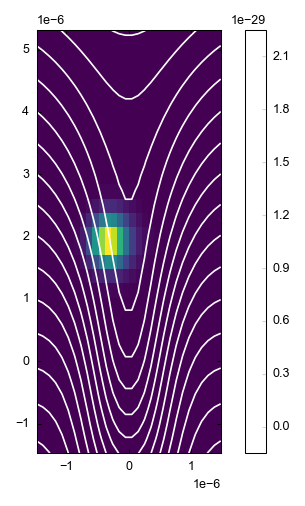

In [94]:
plt.imshow(states[0,int(0.5*n_pot_steps)]**2,origin="lower",extent=[np.min(coords[y]),np.max(coords[y]),np.min(coords[z]),np.max(coords[z])],cmap='viridis')
Y ,Z = np.meshgrid(coords[y],coords[z])
plt.contour(Y, Z, potential(coords[x][int(0.5*n_pot_steps)],Y,Z), levels=30, colors='white', linewidths=0.8)
plt.colorbar()

## Do 2D first

In [83]:
n_spill_steps = 100

trap[trap.power_tweezer] = initial_power

spill_power_factor = np.linspace(0.7, 0.52, num=n_spill_steps)
powers = trap[trap.power_tweezer] * spill_power_factor
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 30
# Resolution of the potential when solving numerically
n_pot_steps = 200

energies, states, potential, coords = trap.nstationary_solution(
        (trap.y,trap.z), ((-0.8 * axial_width,0.8 * axial_width),(-0.5 * axial_width, 1.9 * axial_width)), n_pot_steps, k=n_levels)

#energies, states, potential, coords = trap.nstationary_solution(
#        (trap.y,trap.z), ((-0.5 * axial_width,0.5 * axial_width),(-0.2 * axial_width, 1.2 * axial_width)), n_pot_steps, k=n_levels)

pot_ax = trap.subs(trap.get_potential())
pot_diff_ax = sp.diff(pot_ax, trap.z)
pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

barrier = root_scalar(
    pot_diff_ax_numpy,
    x0=1.5 * float(trap.subs(axial_width)),
    fprime=pot_diff2_ax_numpy,
    xtol=1e-18,
    fprime2=pot_diff3_ax_numpy,
).root

# States that are below the potential barrier
bound_states = energies < potential(0,barrier)


# Density of states is larger on the left than on the right
# Likely that the state in question is a true bound state
true_bound_states = np.logical_and(
    bound_states,
    np.sum(states[:, coords[z] < barrier] ** 2, axis=(1,2))
    > np.sum(states[:, coords[z] > barrier] ** 2, axis=(1,2)),
)

true_states = np.where(np.sum(states[:, coords[z] < barrier] ** 2, axis=(1,2))
    > np.sum(states[:, coords[z] > barrier] ** 2, axis=(1,2)), True, False)

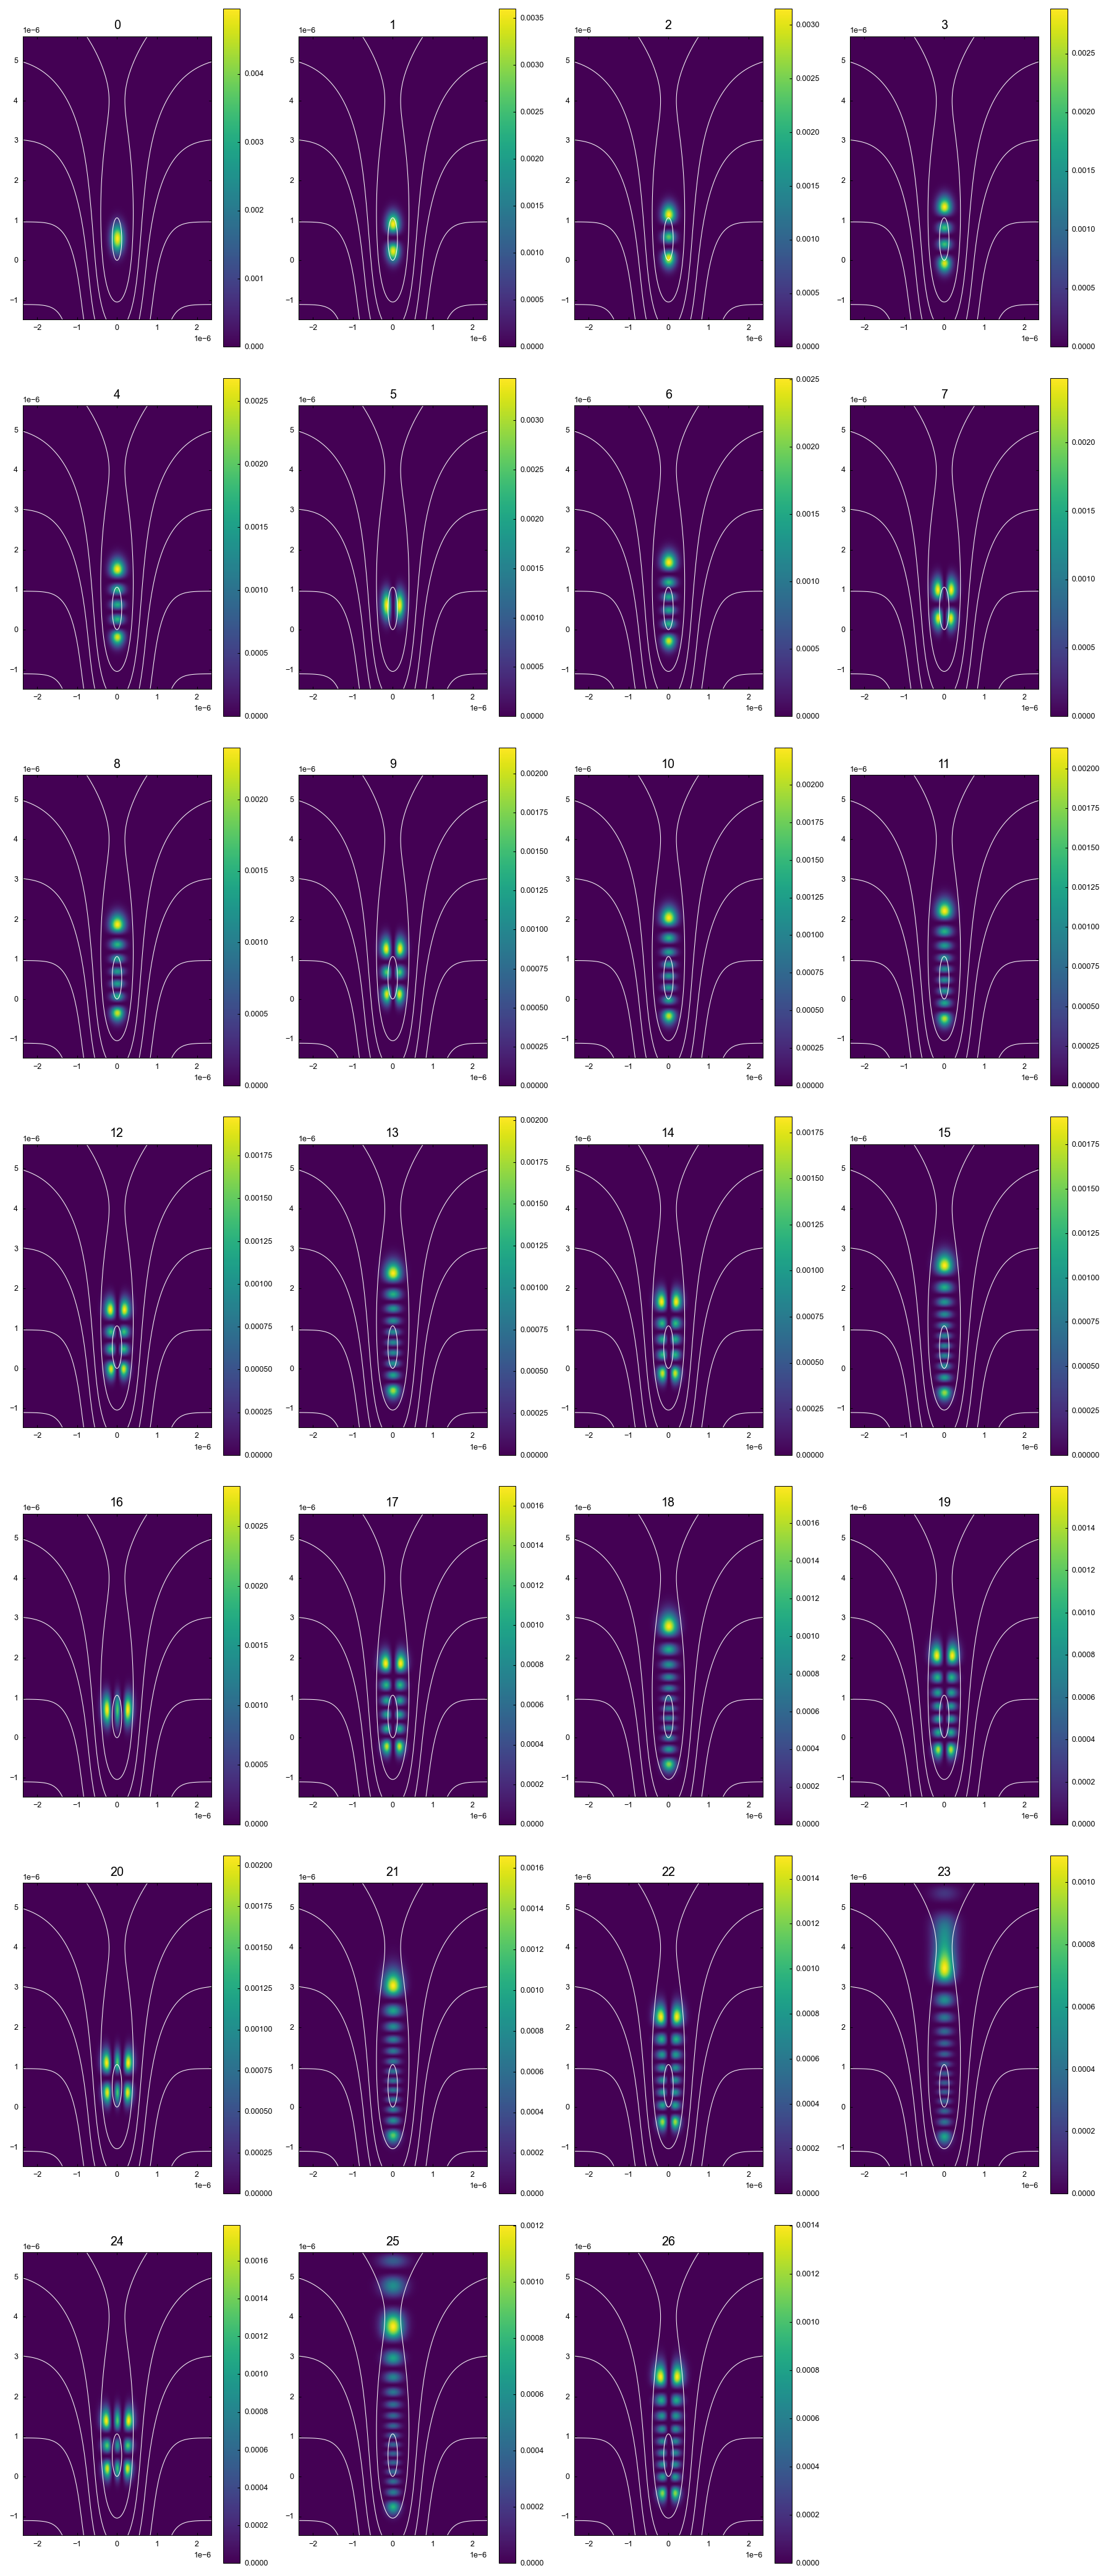

In [84]:
num_plots = np.sum(true_states)
# Determine subplot grid layout
cols = 4  # Number of columns
rows = (num_plots + cols - 1) // cols  # Calculate rows dynamically

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))

# Flatten the axes array for easy iteration (handles single-row/column cases)
axes = axes.flatten()

# Plot data on each subplot
for i, ax in enumerate(axes):
    if i < num_plots:
        im = ax.imshow(states[true_states][i]**2,origin="lower",extent=[np.min(coords[y]),np.max(coords[y]),np.min(coords[z]),np.max(coords[z])],cmap='viridis')
        Y ,Z = np.meshgrid(coords[y],coords[z])
        ax.contour(Y, Z, potential(Y,Z), levels=6, colors='white', linewidths=0.5)
        fig.colorbar(im, ax=ax, orientation='vertical')
        ax.set_title(i)
        #if true_bound_states[i]:
        #    ax.set_title(f"{i}, true bound state")
    else:
        # Hide unused subplots
        ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

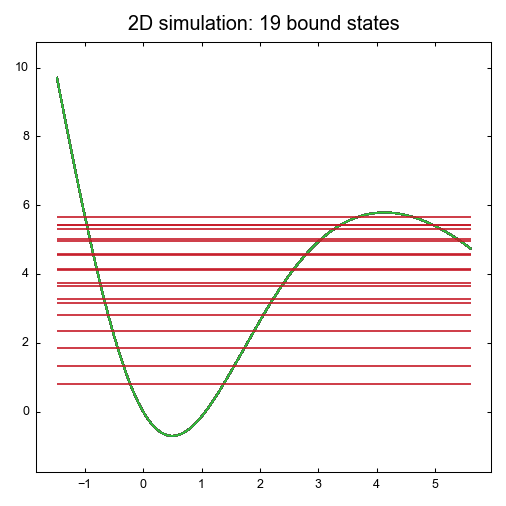

In [85]:
plt.plot(coords[z]/ si.um,potential(Y*0,Z) / const.h / si.kHz,marker="None")
plt.hlines(energies[true_bound_states] / const.h / si.kHz,np.min(coords[z])/ si.um,np.max(coords[z])/ si.um)
#plt.vlines(barrier/si.um,-2,12)
plt.title(f"2D simulation: {np.sum(true_bound_states)} bound states")
plt.show()

[4.84434856e+47 9.50548598e+40 1.05725098e+35 3.22570673e+29
 2.20825632e+24 3.11338011e+19 8.70485803e+14 4.78539256e+10
 5.26285312e+06 1.21862175e+03 6.68379551e-01 1.17123191e-03] s
-6.18167887313272e-31


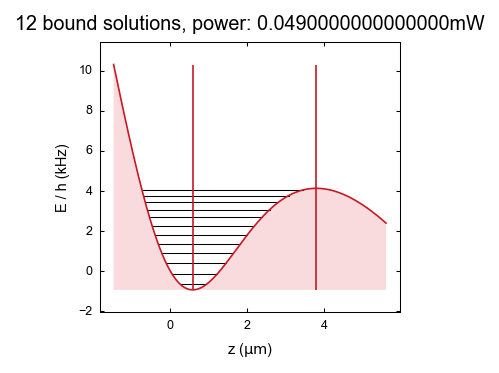

In [81]:
plot_solutions(trap,100,-0.5*zr,1.9*zr,n_pot_steps=1000,display_plot=-2,state_mult=1e3)

<IPython.core.display.Math object>

[1.21523613e+67 4.01805077e+59 7.62262425e+52 3.98990406e+46
 4.67531538e+40 1.11396975e+35 5.12378671e+29 4.42086815e+24
 7.06039691e+19 2.08565083e+15 1.15367133e+11 1.23014918e+07
 2.67364424e+03 1.32463936e+00 2.00627393e-03] s
-4.689134944192487e-31


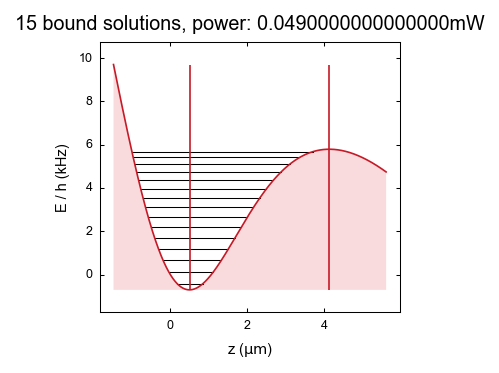

In [82]:
from helpers import *

initial_power = 49 * si.uW

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= -0.8 * si.G / si.cm,
    grad_r=0,
    power_tweezer= initial_power,
    waist_tweezer=1 * si.um,
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 1064 * si.nm,
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

x, y, z = trap.x, trap.y, trap.z

aspect_ratio = trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer()
_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio_latex} \\approx {trap.subs(aspect_ratio).evalf():.2f}"))


plot_solutions(trap,100,-0.5*zr,1.9*zr,n_pot_steps=1000,display_plot=-2,state_mult=1e3)